In [1]:
#|default_exp random_surfaces
from diffusion_curvature.utils import *
from tqdm.auto import tqdm, trange

# Random Surfaces
> A battery of randomly generated manifold surfaces in any dimension, sampled *correctly*, and useful for testing and training models on curvature

There's a general paucity of high-dimensional test data. To test diffusion curvature, we developed a battery of benchmark datasets: randomly generated quadric surfaces in arbitrary dimensions, sampled uniformly *from the manifold space* using rejection sampling. This provides a more challenging benchmark than our toy datasets.

# Function for a random surface

In [2]:
#|export
import sympy as sp
import numpy as np
import itertools

def random_polynomial(
        vars, # variables to construct polynomial from
        degree = 2, # maximum degree of terms
):
    num_variables = len(vars)
    terms = []
    for d in range(1, degree + 1):
        for indices in itertools.combinations_with_replacement(range(num_variables), d):
            terms.append(np.prod([vars[i] for i in indices]))
    coeffs = np.random.normal(size = len(terms))
    return sum([coeffs[i] * terms[i] for i in range(len(terms))])



In [3]:
vars = sp.symbols('x0:%d' % 2)
random_polynomial(vars, degree=2)

0.105689063153309*x0**2 + 1.70779854834346*x0*x1 + 1.05062735874*x0 + 0.899115349348863*x1**2 + 0.461678573665763*x1

To convert our random polynomials into a surface, this function constructs a 1d sympy matrix $f$ where for the first d entries, $f_1 = x_i$. Then, for the remaining $N - d$ entries, $f_i$ is assigned to a random polynomial computed with the random_polynomial function.

In [4]:
#|export
def random_surface(
        d:int, # intrinsic dimension, number of tangent coordinates
        N:int, # ambient dimension,
        degree = 2, # maximum degree of terms
):
    # To convert our random polynomials into a surface, this function constructs a 1d sympy matrix $f$ where for the first d entries, $f_1 = x_i$. Then, for the remaining $N - d$ entries, $f_i$ is assigned to a random polynomial computed with the random_polynomial function.
    # The output is a sympy matrix of size $N \times 1$.
    vars = sp.symbols('x0:%d' % d)
    f = sp.Matrix([*vars])
    for i in range(d, N):
        f = f.row_insert(i, sp.Matrix([random_polynomial(vars, degree)]))
    return f, vars

In [5]:
random_surface(2,4)

(Matrix([
 [                                                                                                                      x0],
 [                                                                                                                      x1],
 [ 0.516704720889851*x0**2 + 1.7339751286124*x0*x1 - 0.86980476596373*x0 - 0.706147034199825*x1**2 + 0.0530019391711184*x1],
 [1.10712427403808*x0**2 + 0.779977501230433*x0*x1 - 0.149864424485627*x0 + 0.165711346034854*x1**2 + 0.495229711445035*x1]]),
 (x0, x1))

# Rejection Sampling

Next, we need to rejection sample $n$ points from the random surface. We're constraining the tangent variables $x_1 \dots x_d$ to range between -1 and 1. (The origin, of course, is our point of interest, where the curvature will be calculated.) 

To rejection sample, we first randomly sample a point $x$ from the proxy distribution, $Y$, given in this case by the naive uniform sampling in euclidean space, mapped into the manifold. We simulatneously sample $u$ from the uniform distribution on the unit interval. Then, if 

$$ u \leq \frac{f(x)}{Mg(x)} $$

we keep x, otherwise we reject it and sample again. Here, $f(x)$ is the true manifold density function at $x$, and $g(x)$ is our proxy - the uniform density over area 4.

$M$ is a constant such that for all inputs considered, $f(x)/g(x) \leq M$. In our case, since $g$ is the uniform density with a constant value, this corresponds to finding the maximum value of $f$ and multiplying it by $4$.

## The Determinant Problem
Rejection sampling requires taking the determinant of the Hessian, which (if using the standard algorithm) increases in terms factorially with the size of the matrix. The default sympy method (Bareiss) is painfully slow here, but the LU or Berkowitz methods do much better.

In [6]:
f, variables = random_surface(4, 5)
G = sp.Matrix.zeros(len(variables), len(variables))
for i, x1 in tqdm(enumerate(variables)):
    for j, x2 in tqdm(enumerate(variables)):
        G[i,j] = (sp.diff(f, x1).T  * sp.diff(f, x2))[0]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
%%time
G.det(method='lu')

CPU times: user 47.6 ms, sys: 3.88 ms, total: 51.4 ms
Wall time: 50.9 ms


(2.69482015467318*(-0.00351947039036393*x0 - 0.258542077089919*x1 - 0.641001223958624*x2 - x3 - 0.354932832696805)**2 + 1)*(3.25109341523161*(-0.235386419435443*x0 - x1 - 0.472214597157351*x2 + 0.250829444607819*x3 - 0.25464981601142)**2 + 1 - 3.25109341523161*(-0.235386419435443*x0 - x1 - 0.472214597157351*x2 + 0.250829444607819*x3 - 0.25464981601142)**2*2.69482015467318*(-0.00351947039036393*x0 - 0.258542077089919*x1 - 0.641001223958624*x2 - x3 - 0.354932832696805)**2/(2.69482015467318*(-0.00351947039036393*x0 - 0.258542077089919*x1 - 0.641001223958624*x2 - x3 - 0.354932832696805)**2 + 1))*(-((-1.05226167299723*x0 - 0.851440162736418*x1 - 1.7020383062319*x2 + 0.236663440190557*x3 - 2.27826827906342)*(-0.424420279416465*x0 - 1.80307887105129*x1 - 0.851440162736418*x2 + 0.452265271809889*x3 - 0.459153702767291) - (-1.05226167299723*x0 - 0.851440162736418*x1 - 1.7020383062319*x2 + 0.236663440190557*x3 - 2.27826827906342)*(-0.424420279416465*x0 - 1.80307887105129*x1 - 0.851440162736418*x

In [8]:
# %%time
# G.det(method='bareiss')

In [9]:
%%time
G.det(method='berkowitz')

CPU times: user 32.4 ms, sys: 655 µs, total: 33.1 ms
Wall time: 32.8 ms


(-2.69482015467318*(-0.00351947039036393*x0 - 0.258542077089919*x1 - 0.641001223958624*x2 - x3 - 0.354932832696805)**2 - 1)*(((-2.69482015467318*(-x0 + 0.275504278283148*x1 + 0.144167138955374*x2 - 0.00500585597073807*x3 - 0.0370592732878752)**2 - 1)*(-5.19050635138661*(-0.461869079540449*x0 - 0.373722520109194*x1 - 0.747075452822263*x2 + 0.103878653082879*x3 - 1)**2 - 1) - 2.69482015467318*(-x0 + 0.275504278283148*x1 + 0.144167138955374*x2 - 0.00500585597073807*x3 - 0.0370592732878752)**2*5.19050635138661*(-0.461869079540449*x0 - 0.373722520109194*x1 - 0.747075452822263*x2 + 0.103878653082879*x3 - 1)**2)*(-3.25109341523161*(-0.235386419435443*x0 - x1 - 0.472214597157351*x2 + 0.250829444607819*x3 - 0.25464981601142)**2 - 1) + (-2.69482015467318*(-x0 + 0.275504278283148*x1 + 0.144167138955374*x2 - 0.00500585597073807*x3 - 0.0370592732878752)**2*3.25109341523161*(-0.235386419435443*x0 - x1 - 0.472214597157351*x2 + 0.250829444607819*x3 - 0.25464981601142)**2 - 5.19050635138661*(-0.4618690

In [10]:
#|export
from tqdm.auto import tqdm
def manifold_density(f, variables):
    G = sp.Matrix.zeros(len(variables), len(variables))
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sp.diff(f, x1).T  * sp.diff(f, x2))[0]
    return sp.sqrt(G.det(method="lu"))

In [11]:
f, vars = random_surface(3,5)
g = manifold_density(f,vars)
g

6.76409022439354*sqrt(7.70812680705935e-17*x0**6 - 9.29368621636931e-17*x0**5*x1 + 1.55299987219455e-16*x0**5*x2 - 2.57139773760337e-16*x0**5 + 1.56664928513376e-16*x0**4*x1**2 + 3.14616598559041e-16*x0**4*x1*x2 - 1.72816733824774e-16*x0**4*x1 + 3.10599974438909e-16*x0**4*x2 + 0.513845525903891*x0**4 - 1.28607801916111e-16*x0**3*x1**3 - 4.74696249996966e-17*x0**3*x1**2*x2 - 2.83756128991796e-16*x0**3*x1**2 - 1.1705319471271e-16*x0**3*x1*x2**2 - 2.11902396501741e-16*x0**3*x1*x2 + 0.12066387931656*x0**3*x1 - 1.94124984024318e-16*x0**3*x2**2 + 0.0618209786481935*x0**3*x2 - 0.177138754030905*x0**3 + 1.26332899759576e-16*x0**2*x1**4 - 2.59642166132526e-16*x0**2*x1**3*x2 + 3.20912864215201e-16*x0**2*x1**3 - 7.34035095841953e-17*x0**2*x1**2*x2**2 - 9.85866764570375e-16*x0**2*x1**2*x2 + 0.445844992606372*x0**2*x1**2 - 1.66067857427053e-17*x0**2*x1*x2**3 + 3.30239963056994e-16*x0**2*x1*x2**2 + 0.280290908994281*x0**2*x1*x2 - 0.781774818113433*x0**2*x1 - 1.06768741213375e-16*x0**2*x2**3 + 0.1220

To get M, we need the max value of $f$. 

In [12]:
#|export
import numpy as np
import scipy.optimize as opt
import sympy as sp

def max_value(expr, bounds):
    # Convert sympy expression to numpy function
    vars = list(expr.free_symbols)
    expr_neg = -1*expr
    neg_func = sp.lambdify([vars], expr_neg, 'numpy')

    # Minimize negative of function over range [-1, 1]
    bounds = [bounds for _ in vars]
    res = opt.minimize(neg_func, np.zeros(len(vars)), bounds=bounds)
    
    # Return maximum value
    return -res.fun


In [13]:
max_value(g, bounds = (-1,1))

12.327938200124354

In [14]:
#|export
def rejection_sample_from_surface(
        F, # a sympy matrix of size $N \times 1$ representing a surface
        n_points, # number of points to sample
        bounds=[-1,1], # bounds for each variable
        batch_size=1024, # number of points to test sampling at a time
        verbose=False,
        seed = None,
):
    np.random.seed(seed)
    if verbose: print("Hey, just woke up")
    vars = list(F.free_symbols)
    f = manifold_density(F, vars)
    g = 1/((bounds[1]-bounds[0])**len(vars)) # uniform density on [-1, 1] for each variable
    M = max_value(f/g, bounds=bounds) # M >= f/g for all x
    if verbose: print("Computed f, M, g")
    bouncer = (f / (M * g)) #.simplify()
    # print(bouncer)
    points = []
    # convert f to numpy
    F_np = sp.lambdify([vars], F, 'numpy')
    bouncer_np = sp.lambdify([vars], bouncer, 'numpy')
    # add the origin as first point
    points.append(F_np(np.zeros(len(vars))))
    if verbose: print("Computed bouncer np")
    while len(points) < n_points:

        euc_coords = np.random.uniform(bounds[0], bounds[1], (batch_size,len(vars)))
        x = np.array(list(map(F_np,euc_coords)))
        if verbose: print("computed sample candidates")
        u = np.random.uniform(0, 1, batch_size)
        # print(u)
        # compute mask of points that pass the bouncer
        bouncer_results = np.array(list(map(bouncer_np,euc_coords)))
        if verbose: print("computed bouncer results")
        mask = u < bouncer_results
        points.extend(x[mask])
        if verbose:
            print(f"Points added {np.sum(mask)} for a total of {len(points)}")
        # if u < bouncer_np(euc_coords):
        #     points.extend(x)
    if len(points) > n_points:
        points = points[:n_points]
    return np.squeeze(np.array(points))

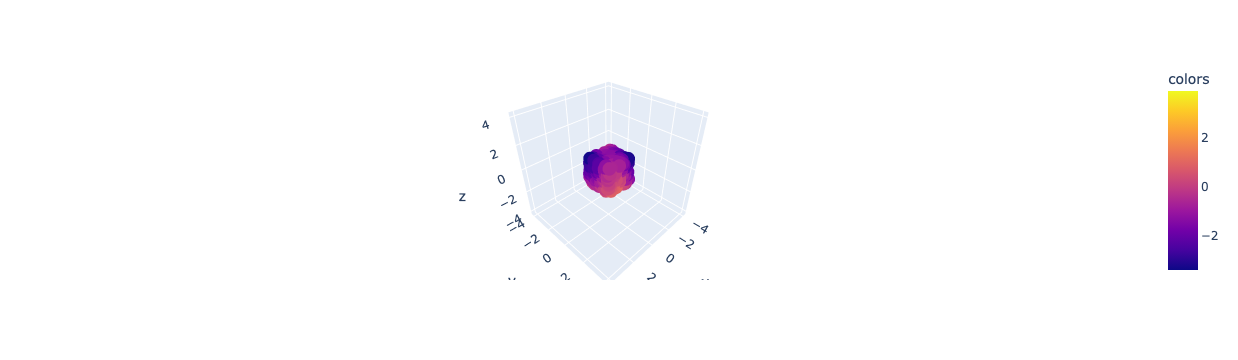

In [33]:
X = rejection_sample_from_surface(f, 1000, seed=42)
plot_3d(X,X[:,-1], use_plotly=True)

In [34]:
X2 = rejection_sample_from_surface(f, 1000, seed=42)

In [35]:
assert np.allclose(X, X2)

# Curvature Computation

Last, we need to compute the scalar curvature of the second point on our random surface. We do this following the method of Sritharan 2021, using the second fundamental form (here, analytically obtained) and Gauss Codazzi to compute the Riemannian curvature tensor, which we contract to the scalar curvature.

In [16]:
#|export
def second_fundamental_form(F):
    vars = list(F.free_symbols)
    d = len(vars)
    N = len(F)
    H = np.zeros([d,d,N-d]) # d x d x (N-d); the last dimension holds the fk's
    for i, x1 in enumerate(vars):
        for j, x2 in enumerate(vars):
            H[j,i] = np.squeeze(sp.diff((sp.diff(F, x1)),x2).subs([(v,0) for v in vars]))[-(N-d):] # evaluate at the origin
    return H

In [17]:
H = second_fundamental_form(f)
print(H.shape)
H

(3, 3, 2)


array([[[ 0.90466615,  0.24378759],
        [-0.64891275,  0.32880774],
        [ 0.16313646,  0.56268692]],

       [[-0.64891275,  0.32880774],
        [ 2.84246455, -2.3525104 ],
        [-0.01983325,  1.66668296]],

       [[ 0.16313646,  0.56268692],
        [-0.01983325,  1.66668296],
        [-0.71318669,  0.92631508]]])

In [18]:
#|export
def riemannian_curvature_tensor(F):
    H = second_fundamental_form(F)
    # print(H)
    N = H.shape[-1]
    d = H.shape[0]
    R = np.zeros((d,d,d,d))
    
    # Edward's method
    # g = np.eye(N)
    # hprod1 = np.einsum('jka,ilb->ijklab',H,H)
    # part1 = np.einsum('ijklab,ab->ijkl',hprod1,g)

    # hprod2 = np.einsum('jib,kla->ijklab',H,H)
    # part2 = np.einsum('ijklab,ab->ijkl',hprod2,g)

    # R = part1 - part2

    # Idx flip suggested by Copilot's autocomplete; it must have seen those flipped idxs in training
    # for i in range(d):
    #     for j in range(d):
    #         for k in range(d):
    #             for l in range(d):
    #                 # We sum over the number of normal functions N-d, representing this value for each fk
    #                 R[i,j,k,l] = np.sum(H[i, k] * H[j, l] - H[i, l] * H[j, k]) # np.sum(H[j,k]*H[i,l] - H[j,i]*H[k,l])
    
    # Sritharan's Method, adapted from [curvature_expression.m · master · hormozlab / ManifoldCurvature · GitLab](https://gitlab.com/hormozlab/ManifoldCurvature/-/blob/master/curvature_expression.m?ref_type=heads)
    # The placement of idxs agrees with the second method, but the values are different
    H2 = np.outer(H.flatten(), H.flatten()).reshape(H.shape + H.shape)
    HC = sum(H2[:,:,i,:,:,i] for i in range(H.shape[-1]))
    ida = [0,2,1,3]
    idb = [2,1,0,3]
    HC_a = np.transpose(HC, ida)
    HC_b = np.transpose(HC, idb)
    R = HC_a - HC_b # Gauss's formula for R_ijkl
    
    return R

In [19]:
#|export
def scalar_curvature_at_origin(F):
    R = riemannian_curvature_tensor(F)
    Ricc = sum([R[:,i,:,i] for i in range(R.shape[-1])])
    S = sum([Ricc[i,i] for i in range(Ricc.shape[-1])])
    # S = 0
    # for i in range(len(R)):
    #     for j in range(len(R)):
    #         S += R[i,j,i,j]
    return S

In [20]:
scalar_curvature_at_origin(f)

-12.556869309775413

# Samples and Curvature

In [21]:
#|export
def samples_from_random_surface(
        n_samples, # number of samples to generate
        d, # intrinsic dimension
        N, # ambient dimension
        degree = 2, # maximum degree of terms
        noise_level = 0, # standard deviation of noise to add to samples
        verbose=False,
):
    F, vars = random_surface(d, N, degree)
    X = rejection_sample_from_surface(F, n_samples, verbose=verbose)
    if noise_level > 0:
        X += np.random.normal(scale = noise_level, size = X.shape)
    k = scalar_curvature_at_origin(F)
    return X, k

In [22]:
X = rejection_sample_from_surface(f, 1000)

# Tests

## Sanity Check on Torus

In [23]:
theta = sp.Symbol('theta')
phi = sp.Symbol('phi')
R = 2
r = 1
F_torus = sp.Matrix([(R + r*sp.cos(theta))*sp.cos(phi), (R + r*sp.cos(theta))*sp.sin(phi), r*sp.sin(theta)])

In [24]:
G_torus = manifold_density(F_torus, [theta, phi])
G_torus

sqrt(sin(phi)**4*sin(theta)**2*cos(theta)**2 + 4*sin(phi)**4*sin(theta)**2*cos(theta) + 4*sin(phi)**4*sin(theta)**2 + 2*sin(phi)**2*sin(theta)**2*cos(phi)**2*cos(theta)**2 + 8*sin(phi)**2*sin(theta)**2*cos(phi)**2*cos(theta) + 8*sin(phi)**2*sin(theta)**2*cos(phi)**2 + sin(phi)**2*cos(theta)**4 + 4*sin(phi)**2*cos(theta)**3 + 4*sin(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**4*cos(theta)**2 + 4*sin(theta)**2*cos(phi)**4*cos(theta) + 4*sin(theta)**2*cos(phi)**4 + cos(phi)**2*cos(theta)**4 + 4*cos(phi)**2*cos(theta)**3 + 4*cos(phi)**2*cos(theta)**2)

In [25]:
X_torus = rejection_sample_from_surface(F_torus, 2000, bounds=[0, 2*np.pi], verbose=True)

Hey, just woke up
Computed f, M, g
Computed bouncer np
computed sample candidates
computed bouncer results
Points added 693 for a total of 694
computed sample candidates
computed bouncer results
Points added 691 for a total of 1385
computed sample candidates
computed bouncer results
Points added 677 for a total of 2062


In [27]:
from diffusion_curvature.benchmarking.hickok import KDE

In [28]:
kde_density = KDE(2, X=X_torus)
density = kde_density.density()

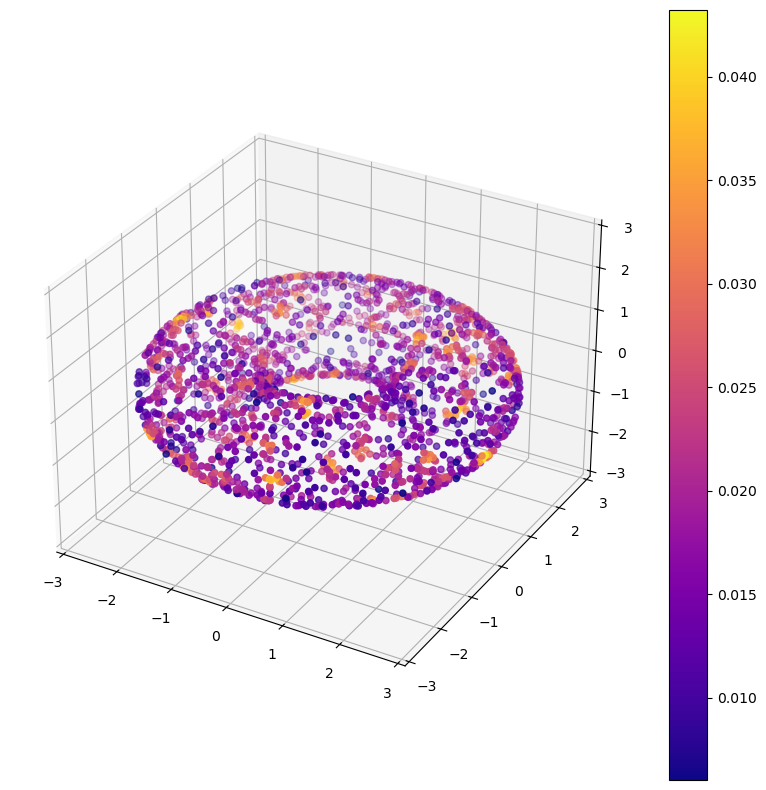

In [29]:
plot_3d(X_torus, density, colorbar=True)

As hoped, the density differences between the outside and inside are negligible.

## Sanity Check on Sphere
To ensure that our curvature computation is working as expected, here's the computation on the upper half of a sphere.

In [30]:
# a sympy function giving the parametrization of the upper half of a sphere in terms of x and y
# creata sympy variables x and y
x = sp.Symbol('x')
y = sp.Symbol('y')
rs = np.array([1,2,3,4,5,6])
ks = []
for r in rs:
    F_sphere = sp.Matrix([x, y, sp.sqrt(r**2 - (x)**2 - (y)**2)])
    X_sphere = rejection_sample_from_surface(F_sphere, 1000, bounds=[-0.6,0.6])
    k_sphere = scalar_curvature_at_origin(F_sphere)
    ks.append(k_sphere)

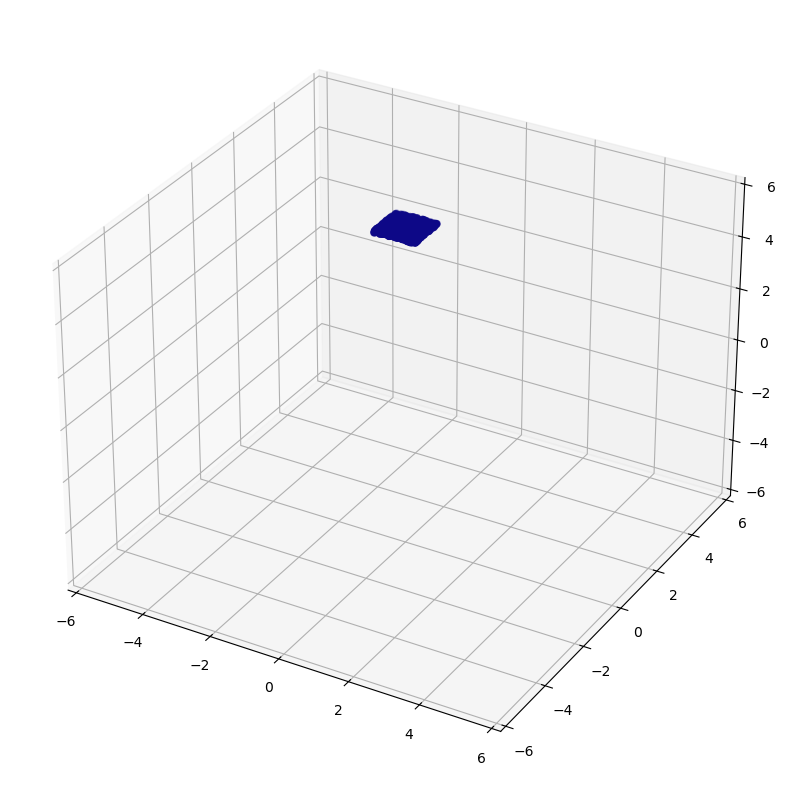

In [31]:
plot_3d(X_sphere)

In [32]:
assert np.allclose(np.array(ks), 2/rs**2)

In [37]:
!nbdev_export